# Using xdggs with IGEO7 DGGRS

IGEO7 dggrs is a hexagonal grid with a refinement ratio of seven that works on icosahedral with ISEA equal area projection. This notebook showcases how to perform data conversion (regridding) from a 2D raster dataset into the igeo7 dggrs dataset. 

In this tutorial, we will use the geotiff of [AQ PM2.5](https://data.opendatascience.eu/geonetwork/srv/eng/catalog.search#/metadata/356923ff-88a1-4770-8bc7-3de7584079be) from [OpenDataScienceEurope](https://data.opendatascience.eu/geonetwork/srv/eng/catalog.search#/home), which Saleem Ibrahim prepares. The geotiff CRS is ``EPSG:3035`` with 1000 m spatial resolution.

We use xarray to load the geotiff.

## Import libraries

Noted that we have to export the DGGRID_PATH before importing the xdggs_dggrid4py library

In [1]:
import os
os.environ['DGGRID_PATH']='/home/dick/micromamba/envs/xdggs/bin/dggrid'
import xarray as xr
import xdggs
import zarr
from xdggs_dggrid4py.regridding import igeo7regridding
from xdggs_dggrid4py.IGEO7 import IGEO7Index

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Registered regridding method centerpoint
Registered regridding method nearestpoint


## Prepare the data for regridding
use xarray to load the geotiff into the variable `data` 

In [2]:
data = xr.open_dataset("https://s3.eu-central-1.wasabisys.com/eumap/aq/aq_pm25_et.eml_m_1km_na_201812_eumap_epsg3035_v0.1prebeta.tif", band_as_variable=True, engine='rasterio')
data

<xarray.Dataset> Size: 54MB
Dimensions:      (x: 3472, y: 3857)
Coordinates:
  * x            (x) float64 28kB 2.542e+06 2.544e+06 ... 6.012e+06 6.014e+06
  * y            (y) float64 31kB 5.418e+06 5.416e+06 ... 1.562e+06 1.562e+06
    spatial_ref  int64 8B ...
Data variables:
    band_1       (y, x) float32 54MB ...
Attributes:
    SCALE_FACTOR:   0.01
    AREA_OR_POINT:  Area

Then, we need to specify the attributes of DGGRS for conversion. Those attributes are represented in a dictionary format. The full attributes content of IGEO7 is :

```python
    {    "grid_name": "igeo7",  
             "level": -1,  # You can specify the refinement level for regridding here.
                           # The refinement level will be determined automatically if it is set to -1
          "src_epsg": "EPSG:3035", # the epsg of the data, you may need to change it.
           "method" : "nearestpoint", # method ID that will be use for regridding. (centerpoint , nearestpoint)
       "coordinate" : ["x","y"], # what are the coordinate dimension in the xarray.
               "mp" : 6, # for multiprocessing, number of processors that you want to use
             "chunk" : (200,200), # block size, when given, the whole extent will be processed in smaller blocks.
                                  # default to whole extent. 
    }
```

We then assign the attribute dictionary to one of the data variable's `attrs`. For this example, we assigned it to the coordinate variable `y`.

In [3]:
attrs={"grid_name": "igeo7",
        "level": -1,
        "src_epsg": "EPSG:3035",
        "method" : "nearestpoint",
        "coordinate" : ["x","y"],
        "chunk": (200,200),
        "mp": 6}
data['y'].attrs=attrs

## Regridding to IGEO7 dggrs
We use the `igeo7regridding` function to regride the data into the IGEO7 dggrs.

Notes on performance: 
- with size of 3472 x 3875 pixels and resoultion 9
- Conversion time with whole extent , mp=1 is 8mins (6GB Ram)
- Conversion time with chunk (200x200), mp =6  is 1.5mins (1.5~2GB Ram)

In [4]:
%%time
dggs_data = igeo7regridding(data)

c1 shape: ((3472,)), c2 shape: ((3857,))
Calculate Auto resolution
Total Bounds (EPSG:3035): [2542500. 1561500. 6013500. 5417500.]
Total Bounds (wgs84): [-33.13136656  35.06597435  51.54843604  67.09363937]
Total Bounds Area (km^2): 20793600.108343568
Area per center point (km^2): 1.5527456892327829
Auto resolution : 9, area: 1.2639902 km2
--- Multiprocessing 6, jobs: 360, job size: 40000, chunk: (200, 200)  ---
--- Generate cells ID at level 9 by nearestpoint


  0%|          | 0/360 [00:00<?, ?it/s]

Re-assign data to cells, number of cells: 10589985, not assigned: 3242197, reused: 396630
Stack completed


  0%|          | 0/360 [00:00<?, ?it/s]

b'00562535506'
coordinate created
coordinate assigned
---Generation completed time: (159.49790716171265), number of cells: 10589985 ---
Re-assign data completed
CPU times: user 949 ms, sys: 1.38 s, total: 2.33 s
Wall time: 2min 39s


After conversion, the dataset is transformed into one dimension. The zone IDs of IGEO7 are stored in the data variable `cell_ids` as shown below. 

To use xdggs with the converted dataset, use the `xdggs.decode` function to create the `IGEO7Index` object with the cell_ids data variable. 

In [5]:
dggs_data = xdggs.decode(dggs_data)
dggs_data

<xarray.Dataset> Size: 161MB
Dimensions:      (cell_ids: 13391504)
Coordinates:
    spatial_ref  int64 8B ...
  * cell_ids     (cell_ids) object 107MB '00562535506' ... '00320462600'
Data variables:
    band_1       (cell_ids) float32 54MB dask.array<chunksize=(13391504,), meta=np.ndarray>
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    SCALE_FACTOR:   0.01
    AREA_OR_POINT:  Area

We can use `xarray.to_zarr()` to make the dataset persistent on either local/cloud storage.

But when we load the dataset from the zarr again with xarray, the index is loaded as PandasIndex.

Again, we use the `xdggs.decode` function to re-initialise the index object with the data variable `cell_ids`.

In [7]:
# save it to zarr
compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
zone_id_compressor = zarr.LZMA()
dggs_data.to_zarr(f'dggs_data.zar',encoding={"band_1": {"compressor": compressor},"cell_ids": {"compressor": zone_id_compressor}})

dggs_zarr = xr.open_zarr('./dggs_data.zar')
dggs_zarr

<xarray.Dataset> Size: 161MB
Dimensions:      (cell_ids: 13391504)
Coordinates:
  * cell_ids     (cell_ids) object 107MB '00562535506' ... '00320462600'
Data variables:
    band_1       (cell_ids) float32 54MB dask.array<chunksize=(13391504,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

In [8]:
dggs_zarr = xdggs.decode(dggs_zarr) 
dggs_zarr

<xarray.Dataset> Size: 161MB
Dimensions:      (cell_ids: 13391504)
Coordinates:
  * cell_ids     (cell_ids) object 107MB '00562535506' ... '00320462600'
Data variables:
    band_1       (cell_ids) float32 54MB dask.array<chunksize=(13391504,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

## Demonstration on using xdggs with IGEO7 DGGRS dataset

### Select zones using latitude and longitude

In [ ]:

dggs_zarr_drop_empty_zone = dggs_zarr.where(dggs_zarr.cell_ids != '',drop=True)
dggs_zarr_drop_empty_zone.dggs.sel_latlon(latitude=[44.56375059,44.56369803],longitude=[6.68935115])

<xarray.Dataset> Size: 20B
Dimensions:      (cell_ids: 1)
Coordinates:
  * cell_ids     (cell_ids) object 8B '00615065526'
Data variables:
    band_1       (cell_ids) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    spatial_ref  int64 8B ...
Indexes:
    cell_ids  ISEAIndex(grid_name=IGEO7, level=9)
Attributes:
    AREA_OR_POINT:  Area
    SCALE_FACTOR:   0.01

### Generate zone centroids

In [ ]:
# generate zone's centroids for selected zone ids , if not given, generate all.
# return a data_array
dggs_zarr_drop_empty_zone.dggs.cell_centers()

  0%|          | 0/50747 [00:00<?, ?it/s]

<xarray.Dataset> Size: 81MB
Dimensions:    (cell_ids: 10149307)
Coordinates:
    latitude   (cell_ids) float32 41MB 66.64 66.64 66.63 ... 35.27 35.26 35.25
    longitude  (cell_ids) float32 41MB -33.14 -33.11 -33.11 ... 28.61 28.61 28.6
Dimensions without coordinates: cell_ids
Data variables:
    *empty*

### Generate polygon for zones and plotting with geopanda

In [ ]:
# generate zone's polygon for selected zone ids , if not given, generate all.
# return a data_array , becare of memory usage, polygons are return as list of shapely object.
dggs_polygon = dggs_zarr_drop_empty_zone.dggs.cell_boundaries()
# we have to convert it to a dataset to merge with the data
dggs_polygon = dggs_polygon.to_dataset(name='polygon')
# before we merge, create the IGEO7 index for the dggs_polygon.
dggs_polygon = xdggs.decode(dggs_polygon)
dggs_polygon = xr.merge([dggs_zarr_drop_empty_zone, dggs_polygon])

  0%|          | 0/50747 [00:00<?, ?it/s]

In [12]:
# plotting 
dggs_polygon = dggs_polygon.to_dataframe().reset_index()

<Axes: >

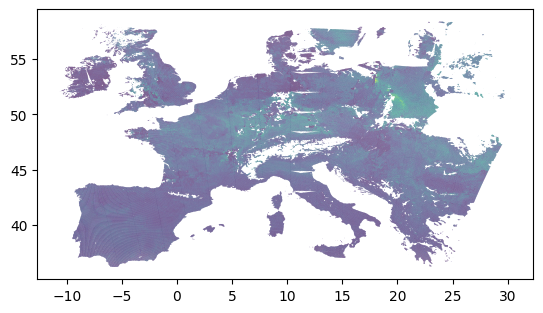

In [13]:
dggs_polygon = dggs_polygon.set_geometry('polygon')
dggs_polygon.dropna().plot(column='band_1')